In [10]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import os


X_train = pd.read_csv('Data/X_train.csv').values
y_train = pd.read_csv('Data/y_train.csv')['label'].values

Shape of training set: (10000, 300)
Shape of labels: (10000,)
Class distribution:
0       18
1        7
2        7
3       65
4      238
5     4479
6      553
7      103
8      516
9       25
10    1081
11      78
12     457
13      62
14     264
15      26
16       6
17     354
18      60
19     177
20     153
21     269
22       7
23      41
24     385
25     184
26     278
27     107
Name: count, dtype: int64
Imbalance ratio between largest and smallest class: 746.5


/var/folders/vx/tr_ckzyj0nzb1934vyp78y040000gn/T/ipykernel_78784/272910229.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


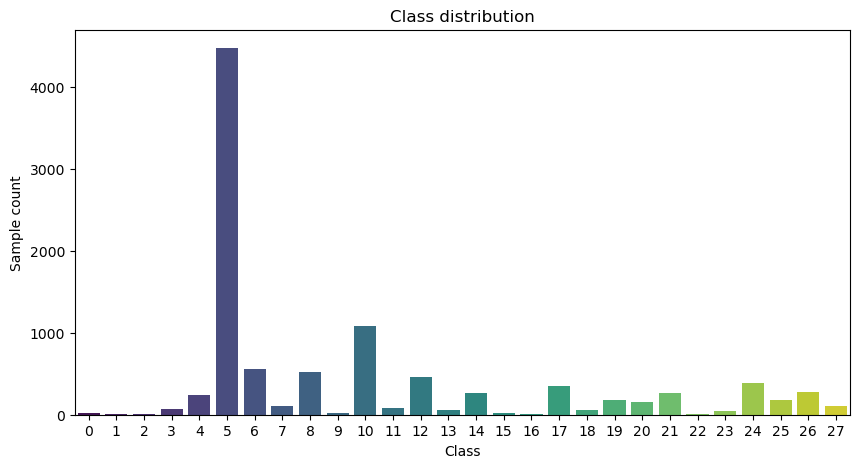

Sample count S: 357
Class 0 , Sample count: 18
Class 1 , Sample count: 7
Class 2 , Sample count: 7
Class 3 , Sample count: 65
Class 4 , Sample count: 238
Class 5 , Sample count: 4479
Class 6 , Sample count: 553
Class 7 , Sample count: 103
Class 8 , Sample count: 516
Class 9 , Sample count: 25
Class 10 , Sample count: 1081
Class 11 , Sample count: 78
Class 12 , Sample count: 457
Class 13 , Sample count: 62
Class 14 , Sample count: 264
Class 15 , Sample count: 26
Class 16 , Sample count: 6
Class 17 , Sample count: 354
Class 18 , Sample count: 60
Class 19 , Sample count: 177
Class 20 , Sample count: 153
Class 21 , Sample count: 269
Class 22 , Sample count: 7
Class 23 , Sample count: 41
Class 24 , Sample count: 385
Class 25 , Sample count: 184
Class 26 , Sample count: 278
Class 27 , Sample count: 107
Total sample count after resampling: 9969
Class distribution after resampling:
0     355
1     357
2     357
3     355
4     357
5     357
6     357
7     355
8     357
9     356
10    357
11 

/var/folders/vx/tr_ckzyj0nzb1934vyp78y040000gn/T/ipykernel_78784/272910229.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resampled_label_counts.index, y=resampled_label_counts.values, palette='viridis')


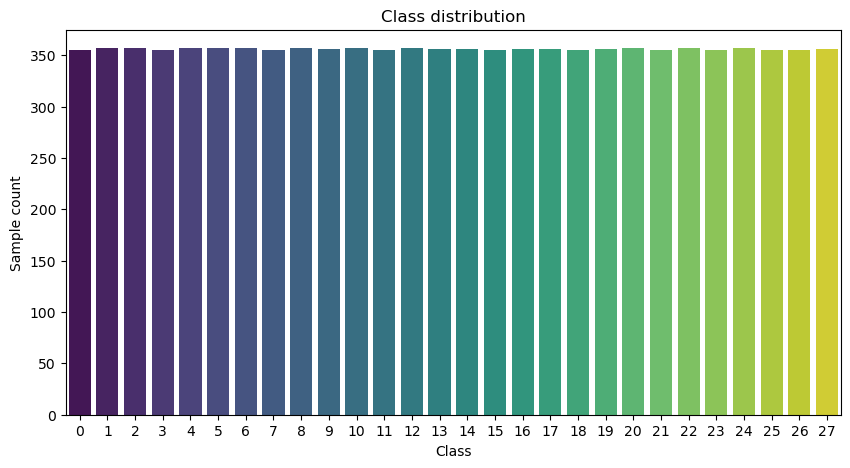

F1-macro cross-validation score of Random Forest on resampled data: 0.8224330858468315


In [11]:
# 1. 
# ----------------------------------
print("Shape of training set:", X_train.shape)
print("Shape of labels:", y_train.shape)

label_counts = pd.Series(y_train).value_counts().sort_index()
print("Class distribution:")
print(label_counts)
imbalance_ratio = label_counts.max() / label_counts.min()
print("Imbalance ratio between largest and smallest class:", imbalance_ratio)

plt.figure(figsize=(10,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Sample count")
plt.show()


# 2. HCBOU
# -------------------------------

# SMOTE-like synthetic sample generation with local interpolation
def generate_synthetic_samples(X_cluster, n_samples, k_neighbors=5, random_state=42):
    np.random.seed(random_state)
    n_samples_cluster = X_cluster.shape[0]
    if n_samples_cluster < 2:
        # If too few samples in cluster, replicate existing ones
        return np.tile(X_cluster, (n_samples, 1))

    nn = NearestNeighbors(n_neighbors=min(k_neighbors, n_samples_cluster)).fit(X_cluster)
    synthetic_samples = []
    for _ in range(n_samples):
        idx = np.random.randint(0, n_samples_cluster)
        sample = X_cluster[idx]
        # Get nearest neighbors
        distances, indices = nn.kneighbors([sample])
        if len(indices[0]) > 1:
            # Randomly choose a neighbor
            neighbor_idx = np.random.choice(indices[0][1:])
        else:
            neighbor_idx = indices[0][0]
        neighbor = X_cluster[neighbor_idx]
        lam = np.random.rand()
        synthetic = sample + lam * (neighbor - sample)
        synthetic_samples.append(synthetic)
    return np.array(synthetic_samples)

def hc_bou_resample(X, y, random_state=42, minority_k=3):

    np.random.seed(random_state)
    unique_labels = np.unique(y)
    C = len(unique_labels)
    N = X.shape[0]
    S = int(np.floor(N / C))
    print(f"Sample count S: {S}")

    X_resampled_list = []
    y_resampled_list = []

    for label in unique_labels:
        idx = np.where(y == label)[0]
        X_class = X[idx]
        n_class = X_class.shape[0]
        # Handling majority class: undersampling
        if n_class >= S:
            print(f"Class {label} , Sample count: {n_class}")
            # KMeans， S 
            km = KMeans(n_clusters=S, random_state=random_state)
            km.fit(X_class)
            X_new = km.cluster_centers_
            y_new = np.full(S, label)
        else:
            print(f"Class {label} , Sample count: {n_class}")
            # Cluster within minority class, with number of clusters minority_k
            km = KMeans(n_clusters=min(minority_k, n_class), random_state=random_state)
            km.fit(X_class)
            labels_cluster = km.labels_
            X_new = X_class.copy()  # Keep original samples
            # Compute number of synthetic samples to generate
            n_to_generate = S - n_class
            synth_samples_all = []
            # ，
            for cluster in np.unique(labels_cluster):
                cluster_idx = np.where(labels_cluster == cluster)[0]
                X_cluster = X_class[cluster_idx]
                weight = X_cluster.shape[0] / n_class
                n_synth = int(np.floor(weight * n_to_generate))
                if n_synth > 0:
                    synth_samples = generate_synthetic_samples(X_cluster, n_synth, k_neighbors=5, random_state=random_state)
                    synth_samples_all.append(synth_samples)
            if synth_samples_all:
                synth_samples_all = np.vstack(synth_samples_all)
                X_new = np.vstack([X_new, synth_samples_all])
            else:
                # If no new samples are generated, duplicate random samples
                duplicates = X_class[np.random.choice(n_class, n_to_generate, replace=True)]
                X_new = np.vstack([X_new, duplicates])
            y_new = np.full(X_new.shape[0], label)

        X_resampled_list.append(X_new)
        y_resampled_list.append(y_new)

    # Combine all classes
    X_resampled = np.vstack(X_resampled_list)
    y_resampled = np.hstack(y_resampled_list)
    print("Total sample count after resampling:", X_resampled.shape[0])
    return X_resampled, y_resampled


# 3. 
# ----------------------------------

# Resample using HCBOU algorithm
X_resampled, y_resampled = hc_bou_resample(X_train, y_train, random_state=42, minority_k=3)

# 
resampled_label_counts = pd.Series(y_resampled).value_counts().sort_index()
print("Class distribution after resampling:")
print(resampled_label_counts)

plt.figure(figsize=(10,5))
sns.barplot(x=resampled_label_counts.index, y=resampled_label_counts.values, palette='viridis')
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Sample count")
plt.show()

# ----------------------------------
# 4. Modeling (Random Forest validation)
# ----------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=42, n_estimators=100)
scores = cross_val_score(clf, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print("F1-macro cross-validation score of Random Forest on resampled data:", scores.mean())

## Save the resampled dataset as seperate files

In [13]:
pd.DataFrame(X_resampled).to_csv("Data/resampled_X_train.csv", index=False)
pd.DataFrame({'label': y_resampled}).to_csv("Data/resampled_y_train.csv", index=False)